# A-B тестирование





## Мотивационный пример

Принесёт ли изменение модели машинного обучения (логрег заменим на catboost) в сервисе ранжирования рекламных объявлений бОльшую конверсию просмотров объявления в клик?

* Нужно правильно выбрать метрику
* * Конверсия просмотра в клик? Или что-то глубже? Покупка на сайте после перехода?
* Нужно правильно подобрать размер выборки
* * есть калькуляторы АБ-тестов (в больших компаниях есть свои, реализуется функцией)
* А как выбирать данные?
* * Применение ранговых критериев для проверки однородности выборок (Манн-Уитни и все другие с прошлого семинара)
* * В рекламных платформах используется C++ / Go сервис, который помогает одного и того же пользователя всегда закидывать в конкретную выборку (А или Б)

Что может пойти не так?
* неправильно поделили на группы (полный рандом, который привёл к тому, что сегодня сайт открывается в одном дизайне, завтра - в другом, послезавтра - снова в изначальном)

## Определения

* A/B-тестирование - метод исследования, с помощью которого проверяется, даёт ли изменение положительный эффект и какое из изменений даст бОльший эффект.

* *  Цель проведения A/B-теста: определение эффекта от внедрения технических инструментов и решений, ввода новых практик или изменения текущих, оптимизирующих бизнес-процессы при помощи проведения расчетов соответствующих ключевых показателей. При таком тестировании используется принцип сравнения полученных результатов по ключевым показателям в целевой и контрольной группах объектов тестирования.

* Выборка (общая выборка) - выборка из генеральной совокупности объектов тестирования, удовлетворяющих условиям кампании, которая в заданной пропорции делится на контрольную и тестовую группу.
* Целевая (контрольная) группа - не подвергается изменениям (А)
* Тестовая группа - производятся изменения (В)
* Note: обычно разбиение контрольной и тестовой групп происходит в соотношении 50/50

* MDE -  это минимально обнаруживаемый эффект на заданном уровне значимости с заданной мощностью, влияющий на размер выборки. Другими словами это минимальный размер эффекта, который должен быть обнаружен с определенной вероятностью и который "оправдывал" бы реализацию тестируемого воздействия. (считается на основе ретро-данных, нужен для определения времени эксперимента и объёма выборки, необходимого для детекции эффекта, нельзя использовать для оценки качества эксперимента!)

$$n = (Var[X_A] + Var[X_B]) \cdot \frac{(z_{\alpha/2}+z_{\beta})^2}{MDE^2}$$

* А/А/В-тестирование - метод исследования, где контрольная группа делится на две, чтобы дополнительно в онлайне проверить её однородность (в т.ч. с помощью ранговых критериев). Если p-value гипотезы о равенстве метрик в двух группах А ниже заданного значения, то эксперимент признаётся невалидным.

* Как провести А/А/В?
0. А - логрег для ранжирования рекламы. В - катбуст для ранжирования рекламы. Берём выборку из всей генеральной совокупности пользователей.
1. Разбиение выборки пользователей сайтов в соотношении 33/33/34
1. * Проверка однородности взятых групп с помощью Манна-Уитни и других критериев однородности (t-тест)
2. Если А/А тест показывает значимые различия (p-value гипотезы об однородности < 0.5), то результат А/В теста нельзя считать валидным, поскольку повышается вероятность того, что разница в А и В обусловлена неоднородностью А выборки. То есть взятая нами выборка плохая и неоднородна (есть неучтённые факты)
3. Решение - стратификация на уровне сэмплирования


**Метрики**

* Конверсия - отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия (скрытые или прямые указания рекламодателей, продавцов, создателей контента — покупку, регистрацию, подписку, посещение определённой страницы сайта, переход по рекламной ссылке), к общему числу посетителей сайта, выраженное в процентах
* CTR - доля кликнувших от всех просмотревших (используется в рекламных платформах)
* LTV - пожизненная ценность клиента, какой чистый доход принесёт клиент (используется в стриминговых сервисах, страховых компаниях)

* Uplift - отношение метрики на тестовой группе к метрике на контрольной группе

## Задача 1 (дизайн эксперимента, два скрина с сайта, моделирование поведения и расчёт метрик)

Копипаст с ссылочки https://thecleverprogrammer.com/2023/07/24/a-b-testing-of-themes-using-python/

* Theme: dark or light
* Click Through Rate: The proportion of the users who click on links or buttons on the website.
* Conversion Rate: The percentage of users who signed up on the platform after visiting for the first time.
* Bounce Rate: The percentage of users who leave the website without further interaction after visiting a single page.
* Scroll Depth: The depth to which users scroll through the website pages.
* Age: The age of the user.
* Location: The location of the user.
* Session Duration: The duration of the user’s session on the website.
* Purchases: Whether the user purchased the book (Yes/No).
* Added_to_Cart: Whether the user added books to the cart (Yes/No)

Работаем с бакетизированными данными, где за основу для бакетизации являются столбцы `Theme, Age, Location, Purchases, Added_to_Cart`

Что такое бакетизация?
* У нас есть 100000 клиентов сайта
* группируем их по столбцам для бакетизации по равным корзинам одинаковой размерности (желательно побольше, в районе 1000+)
* считаем метрики остальные (доля кликов на сайте, доля конверсии в регистрацию на сайте, средняя глубина скролла мышкой, среднее время сессии)

Зачем это делается?
* для того, чтобы целевая метрика была асимптотически нормально распределённой (для метрик отношения)


In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.descriptivestats as sms
from scipy import stats


data = pd.read_csv('https://statso.io/wp-content/uploads/2023/07/website_ab_test.csv')
data

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,No,Yes
1,Light Theme,0.113932,0.032973,0.732759,61.858568,19,Pune,303,No,Yes
2,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,Yes,Yes
3,Light Theme,0.485836,0.325225,0.245001,76.305298,58,Pune,385,Yes,No
4,Light Theme,0.034783,0.196766,0.765100,48.927407,25,New Delhi,1437,No,No
...,...,...,...,...,...,...,...,...,...,...
995,Dark Theme,0.282792,0.401605,0.200720,68.478822,25,Kolkata,321,Yes,Yes
996,Dark Theme,0.299917,0.026372,0.762641,73.019821,38,Chennai,1635,Yes,Yes
997,Light Theme,0.370254,0.019838,0.607136,33.963298,32,Bangalore,1237,No,Yes
998,Light Theme,0.095815,0.137953,0.458898,37.429284,24,Chennai,893,Yes,No


In [ ]:
data.describe()

,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Session_Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.256048,0.253312,0.505758,50.319494,41.528000,924.999000
std,0.139265,0.139092,0.172195,16.895269,14.114334,508.231723
min,0.010767,0.010881,0.200720,20.011738,18.000000,38.000000
25%,0.140794,0.131564,0.353609,35.655167,29.000000,466.500000
50%,0.253715,0.252823,0.514049,51.130712,42.000000,931.000000
75%,0.370674,0.373040,0.648557,64.666258,54.000000,1375.250000
max,0.499989,0.498916,0.799658,79.997108,65.000000,1797.000000


In [ ]:
data.loc[(data.Theme=='Dark Theme') & (data.Age==52) & (data.Location=='Bangalore') & (data.Purchases=='No')]

,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart
219,Dark Theme,0.343755,0.261096,0.703627,68.851440,52,Bangalore,611,No,Yes
336,Dark Theme,0.342370,0.052069,0.512173,25.373241,52,Bangalore,1005,No,Yes
384,Dark Theme,0.115671,0.163568,0.498643,21.327853,52,Bangalore,1194,No,Yes
799,Dark Theme,0.489176,0.429721,0.327042,77.671771,52,Bangalore,1723,No,Yes


In [ ]:
# Scatter plot for Click Through Rate and Conversion Rate
fig = px.scatter(data, x='Click Through Rate',
                 y='Conversion Rate', color='Theme',
                 title='CTR vs Conversion Rate', trendline='ols')
fig.show()

In [ ]:
# Extract data for each theme
light_theme_data = data[data['Theme'] == 'Light Theme']
dark_theme_data = data[data['Theme'] == 'Dark Theme']

# Create grouped bar chart for Click Through Rate
fig = go.Figure()

fig.add_trace(go.Histogram(x=light_theme_data['Click Through Rate'], name='Light Theme', opacity=0.6))
fig.add_trace(go.Histogram(x=dark_theme_data['Click Through Rate'], name='Dark Theme', opacity=0.6))

fig.update_layout(
    title_text='Click Through Rate by Theme',
    xaxis_title_text='Click Through Rate',
    yaxis_title_text='Frequency',
    barmode='group',
    bargap=0.1
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=light_theme_data['Conversion Rate'],
                           name='Light Theme', opacity=0.6, nbinsx=20))
fig.add_trace(go.Histogram(x=dark_theme_data['Conversion Rate'],
                           name='Dark Theme', opacity=0.6, nbinsx=20))

fig.update_layout(
    title_text='Conversion Rate by Theme',
    xaxis_title_text='Conversion Rate',
    yaxis_title_text='Frequency',
    barmode='group',
    bargap=0.1
)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=light_theme_data['Bounce Rate'],
                     name='Light Theme'))
fig.add_trace(go.Box(y=dark_theme_data['Bounce Rate'],
                     name='Dark Theme'))

fig.update_layout(
    title_text='Bounce Rate by Theme',
    yaxis_title_text='Bounce Rate',
)

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=light_theme_data['Scroll_Depth'],
                     name='Light Theme'))
fig.add_trace(go.Box(y=dark_theme_data['Scroll_Depth'],
                     name='Dark Theme'))

fig.update_layout(
    title_text='Scroll Depth by Theme',
    yaxis_title_text='Scroll Depth',
)

fig.show()

In [ ]:
# A/B testing for Purchases
light_theme_conversions = light_theme_data[light_theme_data['Purchases'] == 'Yes'].shape[0]
light_theme_total = light_theme_data.shape[0]

dark_theme_conversions = dark_theme_data[dark_theme_data['Purchases'] == 'Yes'].shape[0]
dark_theme_total = dark_theme_data.shape[0]

conversion_counts = [light_theme_conversions, dark_theme_conversions]
sample_sizes = [light_theme_total, dark_theme_total]

light_theme_conversion_rate = light_theme_conversions / light_theme_total
dark_theme_conversion_rate = dark_theme_conversions / dark_theme_total

# Perform two-sample proportion test
zstat, pval = proportions_ztest(conversion_counts, sample_sizes)
print("Light Theme Conversion Rate: %.3f" % light_theme_conversion_rate)
print("Dark Theme Conversion Rate: %.3f" % dark_theme_conversion_rate)
print("A/B Testing - z-statistic: %.3f, p-value %.3f" % (zstat, pval))

Light Theme Conversion Rate: 0.531
Dark Theme Conversion Rate: 0.504
A/B Testing - z-statistic: 0.853, p-value 0.394


Положительное значение z-статистики указывает на то, что коэффициент конверсии светлой темы немного выше, чем коэффициент конверсии темной темы.

Нулевая гипотеза предполагает, что между двумя темами нет статистически значимой разницы в показателях конверсии

Поскольку p-значение превышает любой разумный уровень значимости, у нас недостаточно доказательств, чтобы отклонить нулевую гипотезу. Это означает, что наблюдаемая разница в коэффициентах конверсии между двумя темами не является статистически значимой. Результаты показывают, что любая наблюдаемая разница в количестве покупок может быть связана со случайной вариацией, а не с истинной разницей, вызванной темами. Нельзя заключить, что одна тема работает значительно лучше другой с точки зрения конверсии пользователей в покупку на сайте после первого посещения.

In [ ]:
light_theme_session_duration = light_theme_data['Session_Duration']
dark_theme_session_duration = dark_theme_data['Session_Duration']

# Calculate the average session duration for both themes
light_theme_avg_duration = light_theme_session_duration.mean()
dark_theme_avg_duration = dark_theme_session_duration.mean()

# Print the average session duration for both themes
print("Light Theme Average Session Duration: %.3f" % light_theme_avg_duration)
print("Dark Theme Average Session Duration: %.3f" % dark_theme_avg_duration)

# Perform two-sample t-test for session duration
tstat, pval = stats.ttest_ind(light_theme_session_duration, dark_theme_session_duration)
print("A/B Testing for Session Duration - t-statistic: %.3f, p-value %.3f" % (tstat, pval))

Light Theme Average Session Duration: 930.833
Dark Theme Average Session Duration: 919.482
A/B Testing for Session Duration - t-statistic: 0.353, p-value 0.724


Нулевая гипотеза в отсутствии значимых различий между влиянием темы на продолжительность сеанса не может быть отвергнута на любом разумном уровне значимости -> не можем заключить, что продолжительность сессии на сайте зависит от цвета темы сайта

## Задача 2 (пост-стратификация эксперимента)

Показать, что полезно сравнивать аплифт в метриках не только по А и Б группам, но и в отдельных разрезах внутри этих групп (пол/возрастные группы, разделение по гео)

In [ ]:
data.Location.value_counts()

Chennai      216
Bangalore    210
New Delhi    194
Pune         192
Kolkata      188
Name: Location, dtype: int64

In [ ]:
data_agg_location = data.groupby('Location').Theme.count().reset_index()
display(data_agg_location)
data_stratification = data.merge(data_agg_location.rename(columns={'Theme':'Location_weight'}), on='Location')
data_stratification['Location_weight'] = data_stratification.Location_weight / len(data_stratification) * len(data_agg_location)
data_stratification

,Location,Theme
0,Bangalore,210
1,Chennai,216
2,Kolkata,188
3,New Delhi,194
4,Pune,192


,Theme,Click Through Rate,Conversion Rate,Bounce Rate,Scroll_Depth,Age,Location,Session_Duration,Purchases,Added_to_Cart,Location_weight
0,Light Theme,0.054920,0.282367,0.405085,72.489458,25,Chennai,1535,No,Yes,1.08
1,Dark Theme,0.323352,0.178763,0.296543,45.737376,47,Chennai,563,Yes,Yes,1.08
2,Light Theme,0.173419,0.266987,0.786825,66.120300,65,Chennai,1244,Yes,No,1.08
3,Light Theme,0.395619,0.210047,0.791166,68.277262,57,Chennai,700,No,No,1.08
4,Light Theme,0.416611,0.100101,0.622703,70.231431,44,Chennai,607,Yes,No,1.08
...,...,...,...,...,...,...,...,...,...,...,...
995,Light Theme,0.228756,0.338312,0.300633,39.752512,24,Bangalore,786,Yes,Yes,1.05
996,Dark Theme,0.031676,0.112745,0.241306,23.491075,29,Bangalore,866,Yes,Yes,1.05
997,Light Theme,0.292963,0.442068,0.740965,70.867878,55,Bangalore,790,Yes,No,1.05
998,Dark Theme,0.388544,0.182103,0.559888,35.579602,55,Bangalore,654,No,No,1.05


In [ ]:
data_stratification.loc[data_stratification.Purchases=='Yes', 'Purchases'] = 1
data_stratification.loc[data_stratification.Purchases=='No', 'Purchases'] = 0

purchased_light_weighted = (data_stratification.loc[data_stratification.Theme=='Light Theme'].Purchases * data_stratification.loc[data_stratification.Theme=='Light Theme'].Location_weight).sum()
purchased_dark_weighted = (data_stratification.loc[data_stratification.Theme=='Dark Theme'].Purchases * data_stratification.loc[data_stratification.Theme=='Dark Theme'].Location_weight).sum()

print('Взвешенное количество бакетов, совершивших покупку в светлой теме = %.2f' % purchased_light_weighted)
print('Взвешенное количество бакетов, совершивших покупку в тёмной теме = %.2f' %  purchased_dark_weighted)

num_light_weighted = (data_stratification.loc[data_stratification.Theme=='Light Theme'].Location_weight).sum()
num_dark_weighted = (data_stratification.loc[data_stratification.Theme=='Dark Theme'].Location_weight).sum()

print('Взвешенное количество бакетов в светлой теме = %.2f' %  num_light_weighted)
print('Взвешенное количество бакетов в тёмной теме = %.2f' %  num_dark_weighted)

light_ratio_weighted = purchased_light_weighted / num_light_weighted
dark_ratio_weighted = purchased_dark_weighted / num_dark_weighted

print('Взвешенная доля покупок в светлой теме = %.4f' %  light_ratio_weighted)
print('Взвешенная доля покупок в тёмной теме = %.4f' %  dark_ratio_weighted)

overall_ratio_weighted = (purchased_light_weighted + purchased_dark_weighted) / (num_dark_weighted + num_light_weighted)

z = (light_ratio_weighted - dark_ratio_weighted) / (np.sqrt(overall_ratio_weighted * (1-overall_ratio_weighted) * (1/num_light_weighted + 1/num_dark_weighted)))
p_value = stats.norm.sf(abs(z)) * 2

print('Значение z-статистики после стратификации = %.4f' %  z)
print('p-value = %.4f' % p_value)

Взвешенное количество бакетов, совершивших покупку в светлой теме = 258.82
Взвешенное количество бакетов, совершивших покупку в тёмной теме = 259.28
Взвешенное количество бакетов в светлой теме = 487.68
Взвешенное количество бакетов в тёмной теме = 515.32
Взвешенная доля покупок в светлой теме = 0.5307
Взвешенная доля покупок в тёмной теме = 0.5031
Значение z-статистики после стратификации = 0.8734
p-value = 0.3824


## Задача 3 (Дельта-метод)

В задачах сравнения метрик отношения часто возникает проблема смещённости выборки. Раскроем мысль на примере:
* Пусть у нас есть рекламная платформа, на которой мы проводим эксперимент по внедрению новой фичи, мы разделили выборку и вроде бы всё хорошо, но мы упустили такой нюанс, что разные пользователи в разной степени склонны кликать на рекламу и в нашей выборке есть три категории
* * те, кто вообще не склонны кликать по рекламе (0 кликов на 1000 показов рекламы за последние 30 дней), при этом они также редко посещают сайты, на которых размещается реклама
* * те, кто кликает на рекламу изредка (1-5 клика на 1000 показов), но регулярно смотрит сайты
* * те, кто часто кликает на рекламу (6+ клика на 1000 показов) и часто посещает сайты

Давайте на этом примере поймём, почему в таком случае традиционные известные нам тесты ломаются
* пусть у нас есть k рекламных компаний, которые мы показали 1000 пользователей
* у нас есть следующая модель, генерящая клики и просмотры для каждого пользователя

1. Сначала мы выбираем, к какой категории пользователей он относится:
1. * с вероятностью 0.7 это малоактивный пользователь, который за время действия эксперимента посетил в-среднем 5 страниц и во время посещений кликает на рекламу с вероятностью 0.001
1. * С вероятностью 0.25 это относительно активный пользователь, который посещает в-среднем 25 страниц и кликает на рекламу с вероятностью 0.01
1. * С вероятностью 0.05 это очень активный пользователь, который посещает в-среднем 100 страниц и кликает на рекламу с вероятностью 0.2
2. При этом известно, что распределение количества просмотров в каждой категории соответствует пуассоновскому распределению, а  распределение количества кликов - биномиальному
3. Создадим 1000 юзеров в рамках такой модели и сравним на А/А тесте, равны ли средние CTR для таких групп

Доля ошибок первого рода: 0.05
Стандартное отклонение средних в А: 0.0015
Стандартное отклонение средних в В: 0.0015


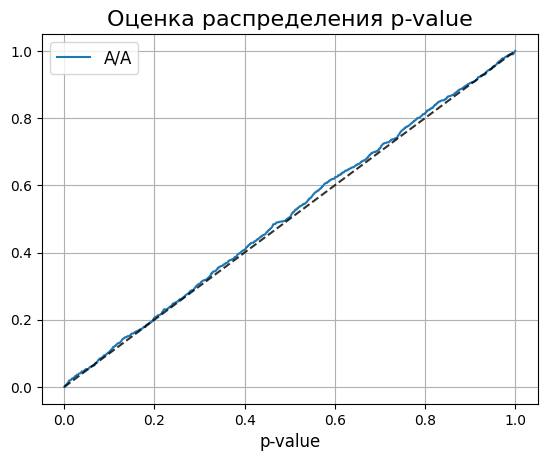

In [ ]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

def generate_data(sample_size, effect: int = 0,
                  pattern_distribution = [0.7, 0.25, 0.05],
                  pattern_view_lambda = [5, 25, 100],
                  pattern_click_proba = [0.001, 0.01, 0.2]):
    """Генерирует данные с количеством кликов на k рекламных компаний.

    sample_size - количество пользователей, просмотревших рекламу
    effect - истинный эффект от внедрения фичи для В-группы
    pattern_distribution - вектор распределения вероятностей принадлежать тому или иному паттерну
    pattern_view_lambda - вектор параметров пуассоновского распределения для количества просмотров пользователем
    pattern_click_proba - вектор параметров биномиального распределения для количества кликов пользователем

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества с количеством кликов по пользователю.
    """
    result = []
    for group_effect in [0, effect]:
        user_pattern_num_views = np.random.choice(pattern_view_lambda, sample_size, p=pattern_distribution)
        user_pattern_click_p = np.zeros_like(user_pattern_num_views)
        for pattern, proba in zip(pattern_view_lambda, pattern_click_proba):
          user_pattern_click_p = np.where(user_pattern_num_views==pattern, proba, user_pattern_click_p)

        num_views_per_user = np.random.poisson(user_pattern_num_views, sample_size)+1
        num_clicks_per_user = np.zeros_like(num_views_per_user)
        for i in range(sample_size):
          num_clicks_per_user[i] = np.random.binomial(num_views_per_user[i], user_pattern_click_p[i]) + group_effect

        ctr = [
            c / v if v != 0 else 0
            for c, v in zip(num_clicks_per_user, num_views_per_user)
        ]
        result.append(ctr)
    return result

alpha = 0.05              # допустимая вероятность ошибки I рода
sample_size = 1000        # размер групп

pvalues = []
a_means, b_means = [], []
for _ in range(1000):
    a, b = generate_data(sample_size, effect=0)
    a_values = np.hstack(a)
    b_values = np.hstack(b)
    pvalue = stats.ttest_ind(a_values, b_values).pvalue
    a_means.append(a_values.mean())
    b_means.append(b_values.mean())
    pvalues.append(pvalue)

error_rate = np.mean(np.array(pvalues) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
print(f'Стандартное отклонение средних в А: {np.array(a_means).std():0.4f}')
print(f'Стандартное отклонение средних в В: {np.array(b_means).std():0.4f}')
plot_pvalue_distribution({'A/A': pvalues})

Вообще, этот пример затевался для того, чтобы показать, что влияние скрытых переменных на целевую метрику ломает вероятность ошибки первого рода при применении традиционных стат гипотез для отношения метрик, но что-то пошло не так и у нас идеально равномерно распределено p-value для 1000 симуляций, что означает корректность теста Стьюдента об однородности выборок

Почему это не должно было работать?

В традиционных тестах мы считаем дисперсию как квадрат стандартного отклонения наблюдаемых значений. [См линк](https://en.wikipedia.org/wiki/Student%27s_t-test#Independent_two-sample_t-test)

Но когда мы считаем целевую метрику для А/В-теста, мы часто имеет дело с метрикой отношений, дисперсия для которой вычисляется несколько сложнее. Воспользуемся формулой дисперсии отношений, вычисленной с помощью [Дельта-метода](https://en.wikipedia.org/wiki/Delta_method)

$$Var\left[\frac{X}{Y}\right] = \frac{Var[X]}{\mu_Y^2}+\frac{\mu_X^2\cdot Var[Y]}{\mu_Y^4}-2\cdot cov(X,Y) \frac{\mu_X}{\mu_Y^3}$$

[Как выводится такая формула](https://stats.stackexchange.com/questions/291594/estimation-of-population-ratio-using-delta-method)

In [ ]:
a, b = generate_data(sample_size, effect=0)
a_values = np.hstack(a)
b_values = np.hstack(b)
a_var = np.sqrt(a_values.mean() * (1 - a_values.mean()) / a_values.shape[0])
b_var = np.sqrt(b_values.mean() * (1 - b_values.mean()) / b_values.shape[0])
print(f'Стандартное отклонение средних в А: {a_var:0.4f}')
print(f'Стандартное отклонение средних в В: {b_var:0.4f}')

Стандартное отклонение средних в А: 0.0035
Стандартное отклонение средних в В: 0.0037


In [ ]:
def generate_data_delta(sample_size, effect: int = 0,
                  pattern_distribution = [0.7, 0.25, 0.05],
                  pattern_view_lambda = [5, 25, 100],
                  pattern_click_proba = [0.001, 0.01, 0.2]):
    """Генерирует данные с количеством кликов на 100 РК.

    sample_size - количество пользователей, просмотревших рекламу
    effect - истинный эффект от внедрения фичи для В-группы

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества с количеством кликов по пользователю.
    """
    result_views, result_clicks = [], []
    for group_effect in [0, effect]:
        user_pattern_num_views = np.random.choice(pattern_view_lambda, sample_size, p=pattern_distribution)
        user_pattern_click_p = np.zeros_like(user_pattern_num_views)
        for pattern, proba in zip(pattern_view_lambda, pattern_click_proba):
          user_pattern_click_p = np.where(user_pattern_num_views==pattern, proba, user_pattern_click_p)

        num_views_per_user = np.random.poisson(user_pattern_num_views, sample_size)+1
        num_clicks_per_user = np.zeros_like(num_views_per_user)
        for i in range(sample_size):
          num_clicks_per_user[i] = np.random.binomial(num_views_per_user[i], user_pattern_click_p[i]) + group_effect

        result_views.append(num_views_per_user)
        result_clicks.append(num_clicks_per_user)
    return result_views, result_clicks

In [ ]:
views, clicks = generate_data_delta(sample_size)
views_a, views_b = views[0], views[1]
clicks_a, clicks_b = clicks[0], clicks[1]

a_values = clicks_a / views_a
b_values = clicks_b / views_b
a_var = np.sqrt(a_values.mean() * (1 - a_values.mean()) / a_values.shape[0])
b_var = np.sqrt(b_values.mean() * (1 - b_values.mean()) / b_values.shape[0])
print(f'Стандартное отклонение в А: {a_var:0.4f}')
print(f'Стандартное отклонение в В: {b_var:0.4f}')

clicks_a_mu = clicks_a.mean()
views_a_mu = views_a.mean()
clicks_a_var, cov_clicks_views_a, _, views_a_var = np.cov(clicks_a, views_a).flatten()
delta_var = (
    1 / views_a_mu**2 * clicks_a_var
    + clicks_a_mu**2 / views_a_mu**4 * views_a_var
    - 2 * clicks_a_mu / views_a_mu**3 * cov_clicks_views_a
)
delta_se = np.sqrt(delta_var / clicks_a.shape[0])
print(f"Стандартное отклонение в А, посчитанное с помощью Дельта-метода: {delta_se:.4f}")

Стандартное отклонение в А: 0.0037
Стандартное отклонение в В: 0.0034
Стандартное отклонение в А, посчитанное с помощью Дельта-метода: 0.0067


По идее, Дельта-метод должен давать значение стандартного отклонения, равное стандартному отклонению средних для 1000 выборок, и более корректно оценивает его, однако на данном примере по какой-то неизвестной составителю семинара причине это сделать не получилось

* [Статья про дельта-метод](https://arxiv.org/pdf/1803.06336.pdf)
* [Как ещё можно проверять однородность двух выборок?](https://stats.stackexchange.com/questions/398436/a-b-testing-ratio-of-sums?noredirect=1&lq=1)

### Ссылочки

* [Гайд по А-Б тестам от академии Яндекса](https://academy.yandex.ru/journal/kak-provesti-a-b-testirovanie-6-prostykh-shagov)
* [Продолжение с примером кода](https://academy.yandex.ru/journal/prostoy-gid-po-bayesovskomu-a-b-testirovaniyu-na-python)
* [Пример](https://cosmiccoding.com.au/tutorials/abtests/)
* [Ещё пример с кодом](https://engineering.tiki.vn/a-b-testing-in-tiki-search/)
* [Что-то на Kaggle](https://www.kaggle.com/code/tammyrotem/ab-tests-with-python)
* [Ещё про логику А-Б тестирования](https://www.statology.org/two-sample-t-test/)
* [Крутая книжка с основами А-Б](https://alexdeng.github.io/causal/abintro.html)
* [Стратификация](https://habr.com/ru/companies/X5Tech/articles/596279/)
* [CUPED](https://habr.com/ru/companies/yandex/articles/497804/)
* [AAB](https://habr.com/ru/articles/323702/)
* [MDE](https://habr.com/ru/companies/lamoda/articles/728034/)
* [Дельта метод](https://habr.com/ru/companies/X5Tech/articles/740476/)
* [Ещё про дельта метод](https://www.aleksjpages.com/posts/delta-method-in-AB-testing)
* [Проверка корректности А-Б](https://habr.com/ru/companies/X5Tech/articles/706388/)
*